In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 397.csv, 514.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=486.00, M2=924.00


In [9]:
only = gp.Model("only")
only.setParam("MIPGap", 1e-7)

x = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = only.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="z")
zc = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = only.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = only.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = only.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

only.update()

obj = gp.quicksum(P_DA[t] * x[i, t] for i, t in product(range(I), range(T))) \
    + gp.quicksum(1 / S * (P_RT[t, s] * yp[i, t, s] - P_PN[t] * ym[i, t, s]) for i, t, s in product(range(I), range(T), range(S)))

only.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    only.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(yp[i, t, s] <= R[i, t, s])
    only.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(zd[i, t, s] <= z[i, t, s])
    only.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    only.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    only.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    only.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    only.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    only.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    only.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
for i, s in product(range(I), range(S)):
    only.addConstr(z[i, 0, s] == K0[i])

only.optimize()

if only.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 21200 rows, 15536 columns and 50000 nonzeros
Model fingerprint: 0xdb0319b6
Variable types: 9776 continuous, 5760 integer (5760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 18008 rows and 12961 columns
Presolve time: 0.16s
Presolved: 3192 rows, 2575 columns, 8094 nonzeros
Variable types: 1615 continuous, 960 integer (960 binary)
Found heuristic solution: objective 691961.41322

Root relaxation: objective 7.176310e+05, 1448 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

In [10]:
da_profit = sum(P_DA[t] * x[i, t].X for i in range(I) for t in range(T))
rt_profit = sum(P_RT[t, s] * yp[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * ym[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost

print("[DISAGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[DISAGGREGATION MODEL]
DA Profit      = 210062.91
RT Profit      = 513930.34
Penalty Cost   = 6400.26
Total Profit   = 717592.98



[ONLY MODEL] Day-Ahead Commitment (sum over DERs):
TOTAL: 1324.00


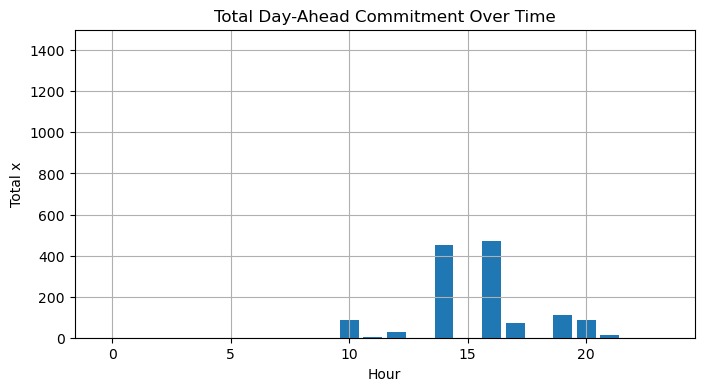

In [11]:
print("\n[ONLY MODEL] Day-Ahead Commitment (sum over DERs):")
total_only_commit = 0
for t in range(T):
    commit_t = sum(x[i, t].X for i in range(I))
    total_only_commit += commit_t
    # print(f"Time {t}: {commit_t:.2f}")
print(f"TOTAL: {total_only_commit:.2f}")

plt.figure(figsize=(8, 4))
plt.bar(range(T), x_vals.sum(axis=0))
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1500)
plt.grid(True)
plt.show()

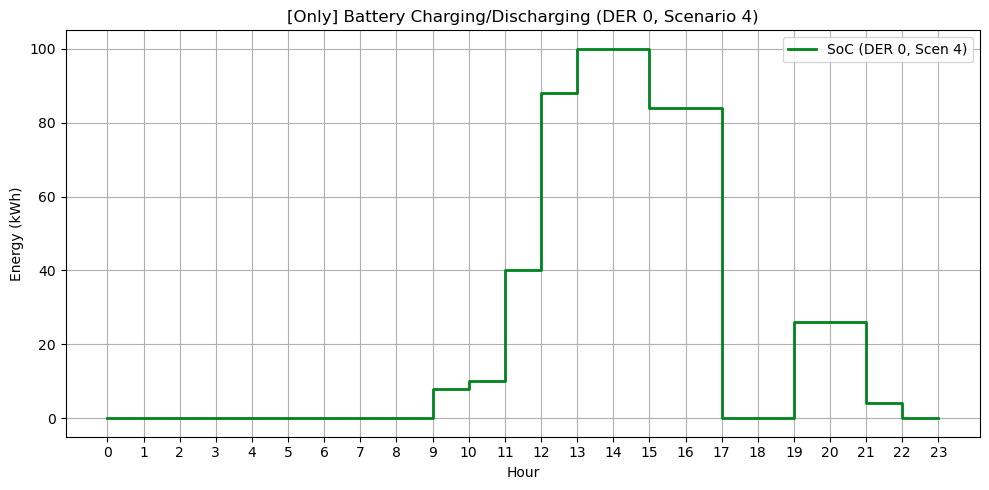

In [12]:
i=0
s=4
zc_single = zc_vals[i, :, s]  
zd_single = zd_vals[i, :, s]
z_single = z_vals[i, :, s]
hours = np.arange(len(zc_single))

plt.figure(figsize=(10, 5))
# plt.step(hours, zc_single, where='post', label=f"Charge (DER {i}, Scen {s})", color = 'green', linestyle = "--", linewidth = 1.5)
# plt.step(hours, zd_single, where='post', label=f"Discharge (DER {i}, Scen {s})", linestyle = "--", color = 'red')
plt.step(hours, z_single, where='post', label=f"SoC (DER {i}, Scen {s})", color='#00821E', linewidth=2)
plt.title(f"[Only] Battery Charging/Discharging (DER {i}, Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Charging/Discharging as first stage variable

In [13]:
# R_forecast = np.mean(R, axis=2) * 0.9

# m = gp.Model("DA_RT_Storage")
# m.setParam("MIPGap", 1e-7)

# # ---------------변수설정----------------
# x = m.addVars(I, T, name="x", lb=0)
# # zc_DA = m.addVars(I, T, name="zc_DA", lb=0)
# # zd_DA = m.addVars(I, T, name="zd_DA", lb=0)
# mu = m.addVars(I, T, vtype=GRB.BINARY, name="mu")

# yp = m.addVars(I, T, S, name="y_plus", lb=0)
# ym = m.addVars(I, T, S, name="y_minus", lb=0)
# z = m.addVars(I, T+1, S, name="z_RT", lb=0)
# zc_RT = m.addVars(I, T, S, name="zc_RT", lb=0)
# zd_RT = m.addVars(I, T, S, name="zd_RT", lb=0)
# rho = m.addVars(I, T, S, vtype=GRB.BINARY, name="rho")
# delta = m.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
# zeta = m.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")

# # --------------목적함수----------------
# m.setObjective(sum(P_DA[t] * x[i, t] for i, t in product(range(I), range(T))) +
#     sum((1 / S) * (P_RT[t, s] * yp[i, t, s] - P_PN[t] * ym[i, t, s]) for i, t, s in product(range(I), range(T), range(S))), GRB.MAXIMIZE)

# # ---------------제약식-----------------
# # for i, t in product(range(I), range(T)):
# #     m.addConstr(x[i, t] - zd_DA[i, t] + zc_DA[i, t] == R_forecast[i, t])
# #     m.addConstr(zc_DA[i, t] <= M1 * mu[i, t])
# #     m.addConstr(zd_DA[i, t] <= M1 * (1 - mu[i, t]))

# for i, t, s in product(range(I), range(T), range(S)):
#     # m.addConstr(zc_DA[i, t] <= K[i] - z[i, t, s])
#     # m.addConstr(zd_DA[i, t] <= z[i, t, s])
#     # m.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc_RT[i, t, s] - zd_RT[i, t, s] + zc_DA[i, t] - zd_DA[i, t])
#     m.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc_RT[i, t, s] - zd_RT[i, t, s])
#     m.addConstr(yp[i, t, s] <= R[i, t, s])
#     m.addConstr(zd_RT[i, t, s] <= z[i, t, s] + zc_DA[i, t] - zd_DA[i, t])
#     m.addConstr(zc_RT[i, t, s] <= K[i] - z[i, t, s] - zc_DA[i, t] + zd_DA[i, t])
#     m.addConstr(z[i, t, s] <= K[i])
#     m.addConstr(z[i, t + 1, s] == z[i, t, s] + zc_DA[i, t] - zd_DA[i, t] + zc_RT[i, t, s] - zd_RT[i, t, s])
#     m.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
#     m.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
#     m.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
#     m.addConstr(zc_RT[i, t, s] <= M1 * (1 - delta[i, t, s]))
#     m.addConstr(zc_RT[i, t, s] <= M1 * zeta[i, t, s])
#     m.addConstr(zd_RT[i, t, s] <= M1 * (1 - zeta[i, t, s]))
# for i, s in product(range(I), range(S)):
#     m.addConstr(z[i, 0, s] == K0[i])
    
# m.optimize()

# x_vals      = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
# # zc_DA_vals  = np.array([[zc_DA[i, t].X for t in range(T)] for i in range(I)])
# # zd_DA_vals  = np.array([[zd_DA[i, t].X for t in range(T)] for i in range(I)])

# yp_vals     = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# ym_vals     = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# z_vals   = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T + 1)] for i in range(I)])
# zc_RT_vals  = np.array([[[zc_RT[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# zd_RT_vals  = np.array([[[zd_RT[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])